# Задача 1

Обучите модель u-net семантической сегментации на встроенном в torchvision датасете Pascal VOC с VGG в качестве энкодера

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.models import vgg16_bn

In [ ]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

class UNetVGG(nn.Module):
    def __init__(self, out_channels=21, pretrained=True):
        super().__init__()

        vgg = vgg16_bn(pretrained=pretrained).features
        self.block1 = nn.Sequential(*vgg[:6])     # 64
        self.block2 = nn.Sequential(*vgg[6:13])   # 128
        self.block3 = nn.Sequential(*vgg[13:20])  # 256
        self.block4 = nn.Sequential(*vgg[20:27])  # 512
        self.block5 = nn.Sequential(*vgg[27:34])  # 512
        self.bottleneck = nn.Sequential(*vgg[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(1024, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(768, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(384, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(192, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(96, 32)

        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = self.conv6(torch.cat([x, block5], dim=1))
        x = self.up_conv7(x)
        x = self.conv7(torch.cat([x, block4], dim=1))
        x = self.up_conv8(x)
        x = self.conv8(torch.cat([x, block3], dim=1))
        x = self.up_conv9(x)
        x = self.conv9(torch.cat([x, block2], dim=1))
        x = self.up_conv10(x)
        x = self.conv10(torch.cat([x, block1], dim=1))

        return self.final_conv(x)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor()
])

train_dataset = datasets.VOCSegmentation(
    root='./data',
    year='2012',
    image_set='train',
    download=True,
    transform=transform,
    target_transform=target_transform
)

100%|██████████| 2.00G/2.00G [01:30<00:00, 22.0MB/s]


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
model = UNetVGG().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=255)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, masks in tqdm(train_loader):
        images = images.to(device)
        masks = masks.squeeze(1).long().to(device)  # VOC: shape [B, 1, H, W] → [B, H, W]

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:03<00:00, 184MB/s]
100%|██████████| 92/92 [00:54<00:00,  1.69it/s]


Epoch 1/5, Loss: 2.5907


100%|██████████| 92/92 [00:53<00:00,  1.71it/s]


Epoch 2/5, Loss: 2.1794


100%|██████████| 92/92 [00:55<00:00,  1.67it/s]


Epoch 3/5, Loss: 1.9380


100%|██████████| 92/92 [00:55<00:00,  1.65it/s]


Epoch 4/5, Loss: 1.7128


100%|██████████| 92/92 [00:55<00:00,  1.65it/s]

Epoch 5/5, Loss: 1.5294


In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import numpy as np

def decode_segmap(mask, n_classes=21):
    # Цвета Pascal VOC
    label_colors = np.array([
        (0, 0, 0),       # 0=background
        (128, 0, 0),     # 1=aeroplane
        (0, 128, 0),     # 2=bicycle
        (128, 128, 0),   # 3=bird
        (0, 0, 128),     # 4=boat
        (128, 0, 128),   # 5=bottle
        (0, 128, 128),   # 6=bus
        (128, 128, 128), # 7=car
        (64, 0, 0),      # 8=cat
        (192, 0, 0),     # 9=chair
        (64, 128, 0),    # 10=cow
        (192, 128, 0),   # 11=dining table
        (64, 0, 128),    # 12=dog
        (192, 0, 128),   # 13=horse
        (64, 128, 128),  # 14=motorbike
        (192, 128, 128), # 15=person
        (0, 64, 0),      # 16=potted plant
        (128, 64, 0),    # 17=sheep
        (0, 192, 0),     # 18=sofa
        (128, 192, 0),   # 19=train
        (0, 64, 128),    # 20=tv/monitor
    ])

    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)

    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [ ]:
val_dataset = datasets.VOCSegmentation(root='./data', year='2012', image_set='val', download=True, transform=transform, target_transform=transform)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

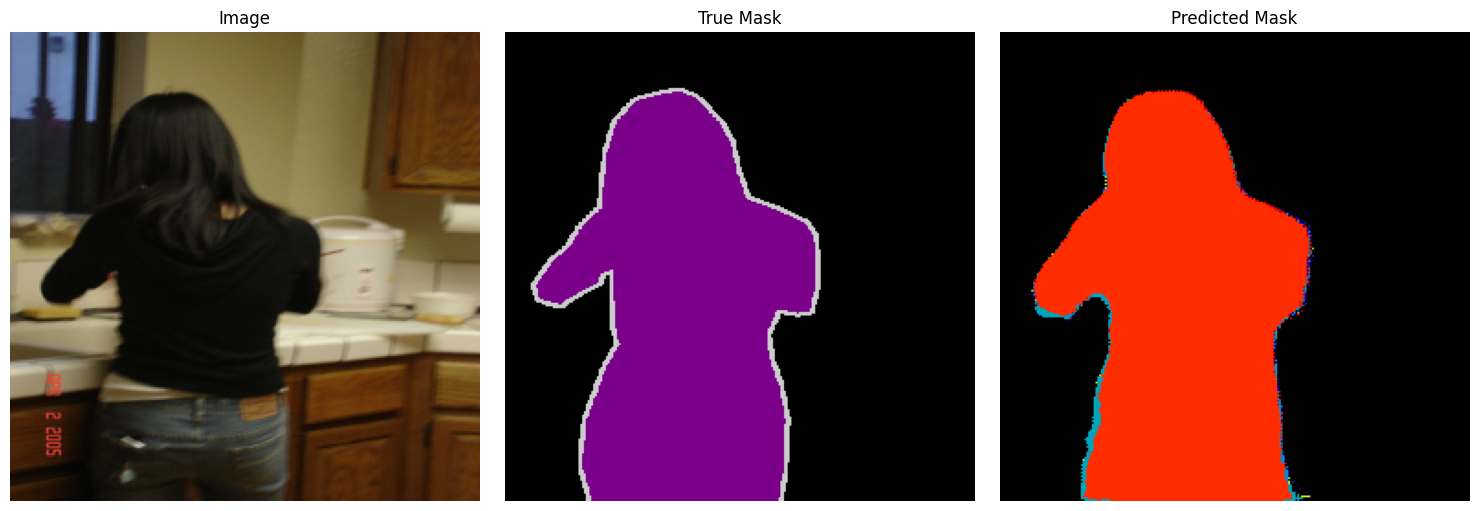

In [ ]:
def visualize_sample(model, dataloader, index=0):
    model.eval()

    # Извлекаем нужный батч из DataLoader
    images, masks = next(iter(dataloader))

    # Извлекаем изображение и маску по индексу
    image = images[index]
    true_mask = masks[index].squeeze(0).cpu().numpy()  # убираем размерность канала

    with torch.no_grad():
        pred = model(image.unsqueeze(0).to(device))  # добавляем размер батча
        pred_mask = torch.argmax(pred.squeeze(), dim=0).cpu().numpy()  # получаем маску с максимальным значением по каналу

    # Визуализация
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(image.permute(1, 2, 0).cpu())  # Перемещаем каналы на последние оси
    axs[0].set_title("Image")

    axs[1].imshow(true_mask, cmap='nipy_spectral')
    axs[1].set_title("True Mask")

    axs[2].imshow(pred_mask, cmap='nipy_spectral')
    axs[2].set_title("Predicted Mask")

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Пример:
visualize_sample(model, val_loader, index=2)

# Задача 2

Обучите модель u-net семантической сегментации на встроенном в torchvision датасете Pascal VOC с ResNet в качестве энкодера

In [ ]:
from torchvision.models import resnet34

In [ ]:
class UNetResNet(nn.Module):
    def __init__(self, out_channels=21, pretrained=True):
        super(UNetResNet, self).__init__()

        # Загружаем предобученную модель ResNet
        resnet = resnet34(pretrained=pretrained)

        # Используем энкодер из ResNet
        self.encoder1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)  # Это будет блок для входа
        self.encoder2 = resnet.layer1  # Первый блок ResNet
        self.encoder3 = resnet.layer2  # Второй блок ResNet
        self.encoder4 = resnet.layer3  # Третий блок ResNet
        self.encoder5 = resnet.layer4  # Четвертый блок ResNet

        # Для декодера создаем обычные слои Conv + Upsampling
        self.up_conv6 = up_conv(2048, 1024)  # Убедитесь, что размер 2048
        self.conv6 = conv(2048, 1024)        # Каналы после upsampling
        self.up_conv7 = up_conv(1024, 512)
        self.conv7 = conv(1024, 512)        # Каналы после upsampling
        self.up_conv8 = up_conv(512, 256)
        self.conv8 = conv(512, 256)         # Каналы после upsampling
        self.up_conv9 = up_conv(256, 128)
        self.conv9 = conv(256, 128)         # Каналы после upsampling
        self.up_conv10 = up_conv(128, 64)
        self.conv10 = conv(128, 64)         # Каналы после upsampling

        # Финальный слой свертки
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Проходим через энкодер (ResNet)
        enc1 = self.encoder1(x)      # (B, 64, H, W)
        enc2 = self.encoder2(enc1)   # (B, 256, H/2, W/2)
        enc3 = self.encoder3(enc2)   # (B, 512, H/4, W/4)
        enc4 = self.encoder4(enc3)   # (B, 1024, H/8, W/8)
        enc5 = self.encoder5(enc4)   # (B, 2048, H/16, W/16)

        # Декодер с upsampling и соединением с энкодерными блоками (skip connections)
        x = self.up_conv6(enc5)
        x = self.conv6(torch.cat([x, enc4], dim=1))  # исправляем количество каналов
        x = self.up_conv7(x)
        x = self.conv7(torch.cat([x, enc3], dim=1))  # исправляем количество каналов
        x = self.up_conv8(x)
        x = self.conv8(torch.cat([x, enc2], dim=1))  # исправляем количество каналов
        x = self.up_conv9(x)
        x = self.conv9(torch.cat([x, enc1], dim=1))  # исправляем количество каналов

        x = self.up_conv10(x)
        x = self.conv10(x)

        return self.final_conv(x)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
model2 = UNetResNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=255)

num_epochs = 5

for epoch in range(num_epochs):
    model2.train()
    total_loss = 0
    for images, masks in tqdm(train_loader):
        images = images.to(device)
        masks = masks.squeeze(1).long().to(device)  # VOC: shape [B, 1, H, W] → [B, H, W]

        outputs = model2(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 2.12 MiB is free. Process 26702 has 14.74 GiB memory in use. Of the allocated memory 14.54 GiB is allocated by PyTorch, and 77.30 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Задача 3

Реализуйте семантическую сегментацию на предобученной Yolo

In [ ]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.8/978.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal


0: 640x640 1 person, 3 airplanes, 2 trucks, 501.3ms
Speed: 11.8ms preprocess, 501.3ms inference, 54.4ms postprocess per image at shape (1, 3, 640, 640)


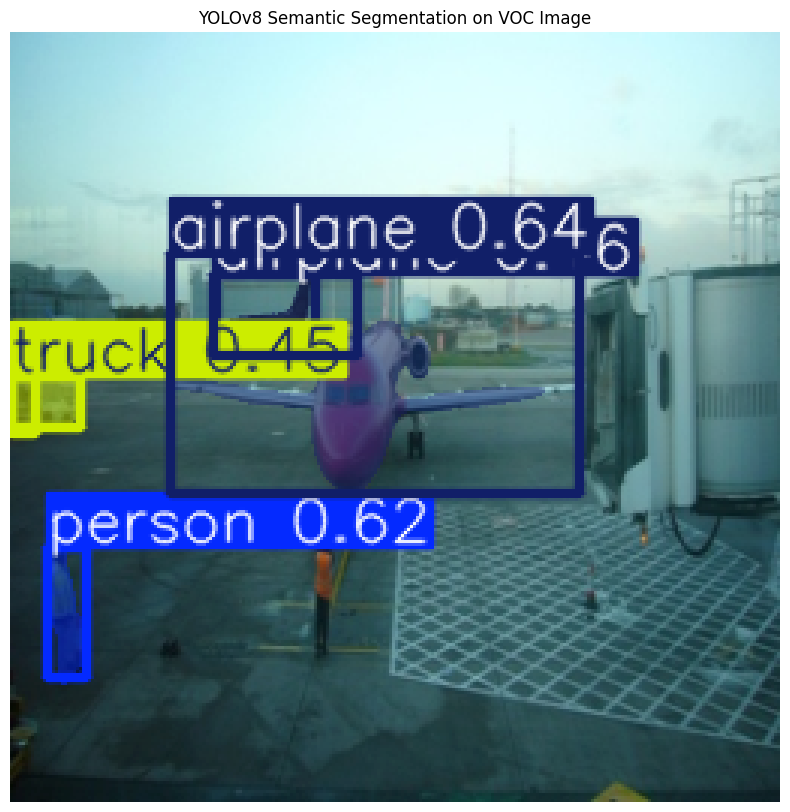

In [ ]:
from ultralytics import YOLO
from torchvision import datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

# Загружаем предобученную модель YOLOv8 для сегментации
model = YOLO('yolov8n-seg.pt')  # Можно заменить на s/m/l/x для большей точности

# Трансформации
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

# Без target_transform — YOLO этого не требует
train_dataset = datasets.VOCSegmentation(
    root='./data',
    year='2012',
    image_set='train',
    download=True,
    transform=transform
)

# Берём изображение из VOC
image_tensor, _ = train_dataset[0]
image_pil = T.ToPILImage()(image_tensor)
image_np = np.array(image_pil)[:, :, ::-1]  # PIL to OpenCV (RGB → BGR)

# Предсказание
results = model(image_np)

# Визуализация
res_img = results[0].plot()

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(res_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("YOLOv8 Semantic Segmentation on VOC Image")
plt.show()